# Introduction

Modern Portfolio Theory (MPT) optimizes asset weights by mean-variance analysis to balance risk against return. Actual markets are not simple, though, and naive covariance estimates can be noisy or unstable with a small sample or volatile assets. In this regard, we utilize a *robust covariance estimation* technique (Ledoit-Wolf) that shrinks the covariance matrix towards a more stable estimate.

Additionally, real-world portfolios are not stationary. Market conditions evolve, so we use a **rolling window** to re-estimate returns and covariance over time. This rolling approach better reflects real-world portfolio rebalancing strategies. Finally, we include multiple asset classes—equities, bonds, commodities, and crypto—to illustrate the benefits of diversification.

# Initial testing with randomized data

In [3]:
!pip install numpy pandas matplotlib scipy


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [5]:
np.random.seed(42)  # For reproducibility

# Simulate monthly returns for 4 assets over 60 months
dates = pd.date_range(start='2020-01-01', periods=60, freq='M')
asset_returns = pd.DataFrame(np.random.randn(60, 4) * 0.02, columns=['Asset_A', 'Asset_B', 'Asset_C', 'Asset_D'], index=dates)

asset_returns.head()


<ipython-input-5-52d76c21017f>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2020-01-01', periods=60, freq='M')


,Asset_A,Asset_B,Asset_C,Asset_D
2020-01-31,0.009934,-0.002765,0.012954,0.030461
2020-02-29,-0.004683,-0.004683,0.031584,0.015349
2020-03-31,-0.009389,0.010851,-0.009268,-0.009315
2020-04-30,0.004839,-0.038266,-0.034498,-0.011246
2020-05-31,-0.020257,0.006285,-0.018160,-0.028246


In [6]:
mean_returns = asset_returns.mean()  # Average monthly returns
cov_matrix = asset_returns.cov()     # Covariance of returns


In [7]:
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights


In [8]:
def target_return_constraint(weights, mean_returns, target_return):
    # We'll use the difference so it must be >= 0
    return (weights.T @ mean_returns) - target_return

# Weights sum-to-1 constraint: sum(weights) = 1
weights_sum_to_1 = {
    'type': 'eq',
    'fun': lambda w: np.sum(w) - 1
}

# Non-negativity bounds for each asset weight
bounds = [(0.0, 1.0)] * len(mean_returns)


In [9]:
results = []
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 20)

for tr in target_returns:
    constraints = (
        weights_sum_to_1,
        {'type': 'ineq', 'fun': target_return_constraint, 'args': (mean_returns, tr)}
    )

    # We need an initial guess: let's do equal weights
    init_guess = np.ones(len(mean_returns)) / len(mean_returns)

    opt_result = minimize(
        fun=portfolio_variance,
        x0=init_guess,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    if opt_result.success:
        w_opt = opt_result.x
        portfolio_return = w_opt @ mean_returns
        portfolio_risk = np.sqrt(w_opt @ cov_matrix @ w_opt)
        results.append({
            'target_return': tr,
            'actual_return': portfolio_return,
            'risk': portfolio_risk,
            'weights': w_opt
        })


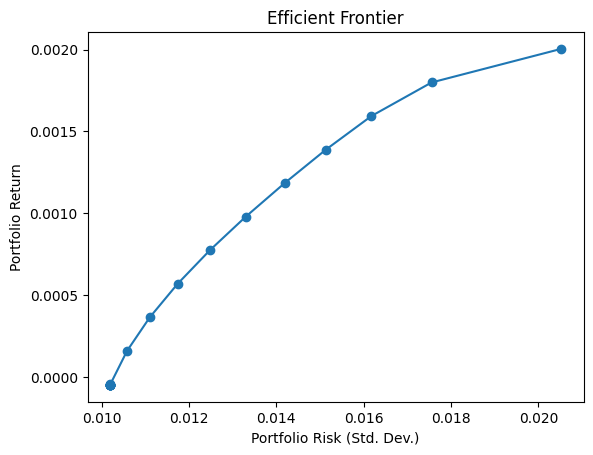

In [10]:
# Convert the results list to a DataFrame
frontier_df = pd.DataFrame(results)

plt.figure()
plt.plot(frontier_df['risk'], frontier_df['actual_return'], marker='o', linestyle='-')
plt.xlabel('Portfolio Risk (Std. Dev.)')
plt.ylabel('Portfolio Return')
plt.title('Efficient Frontier')
plt.show()


# Real Data

In [11]:
from scipy.optimize import minimize
import yfinance as yf

In [12]:
tickers = ["SPY", "AAPL", "MSFT"]
start_date = "2020-01-01"
end_date = "2025-01-01"

data = yf.download(tickers, start=start_date, end=end_date, interval="1mo", auto_adjust=True)['Close']
data.dropna(inplace=True)
data.head()

[*********************100%***********************]  3 of 3 completed


Ticker,AAPL,MSFT,SPY
Date,,,
2020-01-01,74.933746,162.496674,298.283752
2020-02-01,66.181664,154.650101,274.669830
2020-03-01,61.710846,150.956680,238.966354
2020-04-01,71.299095,171.536011,270.894745
2020-05-01,77.157364,175.403015,283.801575


In [13]:
# Sort by date just in case
data = data.sort_index()
returns = data.pct_change().dropna()


In [14]:
annual_risk_free = 0.02
monthly_risk_free = (1 + annual_risk_free)**(1/12) - 1
print("Monthly risk-free rate:", monthly_risk_free)


Monthly risk-free rate: 0.0016515813019202241


In [15]:
mean_returns = returns.mean()
cov_matrix = returns.cov()

print("Mean monthly returns:\n", mean_returns)
print("\nCovariance matrix:\n", cov_matrix)


Mean monthly returns:
 Ticker
AAPL    0.024033
MSFT    0.018257
SPY     0.012888
dtype: float64

Covariance matrix:
 Ticker      AAPL      MSFT       SPY
Ticker                              
AAPL    0.007078  0.003750  0.003415
MSFT    0.003750  0.004176  0.002518
SPY     0.003415  0.002518  0.002903


In [16]:
n_assets = len(tickers)
bounds = [(-2.0, 2.0)] * n_assets

# If you want to keep total weights = 1:
# constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
# If you want to allow arbitrary sums, skip that constraint or set it differently:
constraints = ()


In [17]:
def portfolio_variance(weights, cov):
    """Compute portfolio variance given weights and covariance."""
    return weights.T @ cov @ weights

def portfolio_return(weights, mean_r):
    """Compute portfolio return given weights and mean returns."""
    return weights.T @ mean_r


In [18]:
def min_var_given_return(mean_r, cov, target_return):
    n = len(mean_r)
    init_guess = np.ones(n) / n

    constraints = (
        {'type': 'ineq', 'fun': lambda w: portfolio_return(w, mean_r) - target_return},
    )

    result = minimize(
        fun=portfolio_variance,
        x0=init_guess,
        args=(cov,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return result


# Maximum Sharpe Ratio​

We want to maximize that. Equivalently, we can minimize the negative Sharpe ratio:

In [19]:
def negative_sharpe_ratio(weights, mean_r, cov, rf):
    port_return = portfolio_return(weights, mean_r)
    port_vol = np.sqrt(portfolio_variance(weights, cov))
    return -(port_return - rf) / port_vol

def max_sharpe_ratio(mean_r, cov, rf):
    n = len(mean_r)
    init_guess = np.ones(n) / n
    result = minimize(
        fun=negative_sharpe_ratio,
        x0=init_guess,
        args=(mean_r, cov, rf),
        method='SLSQP',
        bounds=bounds
    )
    return result


# Add a Simple Transaction Cost Penalty

If we’re rebalancing from an old weight vector wold​ to a new weight vector w, a quick approach is:

transaction cost=κ×∑i∣wi−wold,i∣

where κ is a constant representing cost per unit of change in weight. Then, you’d add that cost to the objective function. For example, if you’re minimizing variance + transaction cost:

In [20]:
w_old = np.ones(n_assets) / n_assets  # Suppose you came from an equal-weight portfolio
kappa = 0.001  # Example cost factor

def portfolio_variance_with_tc(weights, cov, w_old, kappa):
    var = portfolio_variance(weights, cov)
    tc = kappa * np.sum(np.abs(weights - w_old))
    return var + tc

# Then you’d pass portfolio_variance_with_tc to minimize, along with (cov, w_old, kappa).


# Generate & Plot the Efficient Frontier (Min Variance)

In [21]:
min_ret = mean_returns.min()
max_ret = mean_returns.max()

target_returns = np.linspace(min_ret, max_ret, 20)
frontier_data = []

for tr in target_returns:
    res = min_var_given_return(mean_returns, cov_matrix, tr)
    if res.success:
        w_opt = res.x
        ret = portfolio_return(w_opt, mean_returns)
        vol = np.sqrt(portfolio_variance(w_opt, cov_matrix))
        frontier_data.append((ret, vol, w_opt))

df_frontier = pd.DataFrame(frontier_data, columns=["Return", "Volatility", "Weights"])


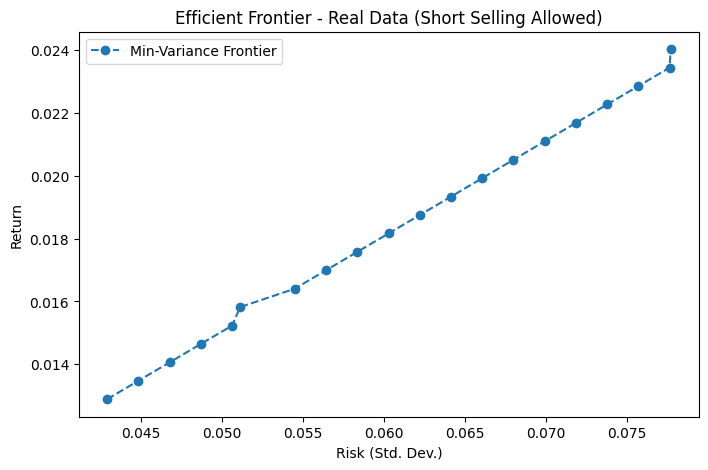

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(df_frontier["Volatility"], df_frontier["Return"], "o--", label="Min-Variance Frontier")
plt.xlabel("Risk (Std. Dev.)")
plt.ylabel("Return")
plt.title("Efficient Frontier - Real Data (Short Selling Allowed)")
plt.legend()
plt.show()


# Compute the Maximum Sharpe Portfolio & Plot Capital Market Line

In [23]:
res_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, monthly_risk_free)
if res_sharpe.success:
    w_sharpe = res_sharpe.x
    ret_sharpe = portfolio_return(w_sharpe, mean_returns)
    vol_sharpe = np.sqrt(portfolio_variance(w_sharpe, cov_matrix))
    sharpe_value = (ret_sharpe - monthly_risk_free) / vol_sharpe
else:
    raise ValueError("Max Sharpe optimization failed.")


We can also plot the Capital Market Line (CML) from the risk-free rate to the tangency (max Sharpe) portfolio:

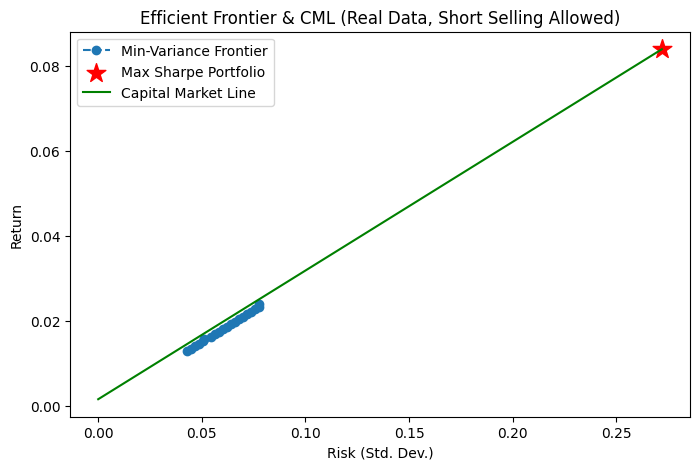

Max Sharpe Portfolio Weights:
 Ticker
AAPL    2.000000
MSFT    2.000000
SPY    -0.045097
dtype: float64
Portfolio Return: 8.3999%, Volatility: 27.1945%, Sharpe: 0.3028


In [24]:
plt.figure(figsize=(8, 5))

# Efficient frontier
plt.plot(df_frontier["Volatility"], df_frontier["Return"], "o--", label="Min-Variance Frontier")

# Tangency portfolio
plt.scatter(vol_sharpe, ret_sharpe, marker='*', color='r', s=200, label="Max Sharpe Portfolio")

# Capital Market Line: from risk-free to tangency
cml_x = np.linspace(0, vol_sharpe, 100)
cml_y = monthly_risk_free + sharpe_value * cml_x
plt.plot(cml_x, cml_y, color='green', label="Capital Market Line")

plt.xlabel("Risk (Std. Dev.)")
plt.ylabel("Return")
plt.title("Efficient Frontier & CML (Real Data, Short Selling Allowed)")
plt.legend()
plt.show()

print("Max Sharpe Portfolio Weights:\n", pd.Series(w_sharpe, index=mean_returns.index))
print(f"Portfolio Return: {ret_sharpe:.4%}, Volatility: {vol_sharpe:.4%}, Sharpe: {sharpe_value:.4f}")


# Robust Covariance Estimation

In [25]:
from scipy.optimize import minimize
from sklearn.covariance import LedoitWolf


## Data Acquisition

We use the `yfinance` library to fetch historical price data for our chosen tickers.
Here, we have announced a list of tickers for different asset classes, such as equities (SPY, QQQ, EFA, EEM),
fixed income (TLT, HYG), commodities (GLD), and crypto (BTC-USD).
We specify a begin and end date, and obtain monthly adjusted close prices.

In [26]:
tickers = [
    "SPY",    # S&P 500
    "QQQ",    # NASDAQ-100
    "EFA",    # iShares MSCI EAFE (Developed)
    "EEM",    # iShares MSCI Emerging Markets
    "TLT",    # iShares 20+ Year Treasury Bond
    "HYG",    # iShares High Yield Corporate Bond
    "GLD",    # SPDR Gold Shares
    "BTC-USD" # Bitcoin (crypto proxy)
]


# Data Cleaning & Setup

We remove any missing values (NaNs) and compute monthly returns
ranked on percentage change in adjusted close prices.
As a sanity test, we'll also look at the top few rows
of our data and some univariate statistics.

In [27]:
start_date = "2020-01-01"
end_date = "2025-01-01"

price_data = yf.download(tickers, start=start_date, end=end_date, interval="1mo", auto_adjust=True)["Close"]
price_data.dropna(inplace=True)  # Drop any rows with NaN
price_data = price_data.sort_index()

# Compute monthly returns
returns_data = price_data.pct_change().dropna()


[*********************100%***********************]  8 of 8 completed


# Robust Covariance (Ledoit-Wolf)

Covariance matrices can be unstable in the case of small samples or volatile assets.
The Ledoit-Wolf method 'shrinks' the sample covariance matrix towards a scaled identity matrix or constant correlation matrix, reducing noise and increasing stability. We are going to use the `LedoitWolf` class from `sklearn.covariance`.


In [28]:
def ledoit_wolf_covariance(returns: pd.DataFrame):
    lw = LedoitWolf().fit(returns.values)
    shrunk_cov = lw.covariance_
    mean_vec = returns.mean().values
    return mean_vec, shrunk_cov

mean_array, cov_matrix_lw = ledoit_wolf_covariance(returns_data)


### Mean-Variance Optimization

We would like to solve the classical Markowitz problem:

In [29]:
def portfolio_return(weights, mean_vec):
    return np.dot(weights, mean_vec)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(weights @ cov_matrix @ weights)

def min_variance_for_target_return(mean_vec, cov_matrix, target_return, bounds, constraints):
    """
    Minimizes variance subject to portfolio return >= target_return and constraints like sum of weights=1, no shorting, etc.
    """
    def portfolio_variance(w):
        return w @ cov_matrix @ w

    # We'll impose the target return as an inequality: portfolio_return(w) - target_return >= 0
    target_return_constraint = {
        'type': 'ineq',
        'fun': lambda w: (w @ mean_vec) - target_return
    }

    all_constraints = [target_return_constraint] + constraints

    n = len(mean_vec)
    init_guess = np.ones(n) / n

    result = minimize(
        fun=portfolio_variance,
        x0=init_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=all_constraints
    )
    return result


# 100% Exposure, no short selling

(No Short, Sum=1)

In [30]:
n_assets = len(tickers)
sum_weights_constraint = {
    'type': 'eq',
    'fun': lambda w: np.sum(w) - 1
}
bounds_no_short = [(0.0, 1.0) for _ in range(n_assets)]  # [0,1] for each asset

constraints_list = [sum_weights_constraint]


Efficient Frontier

We’ll pick a range of target returns between the minimum and maximum of the mean returns array. Note these are raw monthly means from the robust estimator.

In [31]:
min_ret = mean_array.min()
max_ret = mean_array.max()
n_points = 25
target_returns = np.linspace(min_ret, max_ret, n_points)

results = []
for tr in target_returns:
    res = min_variance_for_target_return(
        mean_vec=mean_array,
        cov_matrix=cov_matrix_lw,
        target_return=tr,
        bounds=bounds_no_short,
        constraints=constraints_list
    )

    if res.success:
        w_opt = res.x
        port_ret = portfolio_return(w_opt, mean_array)
        port_vol = portfolio_volatility(w_opt, cov_matrix_lw)
        results.append([port_ret, port_vol, w_opt])

df_frontier = pd.DataFrame(results, columns=["Return", "Volatility", "Weights"])


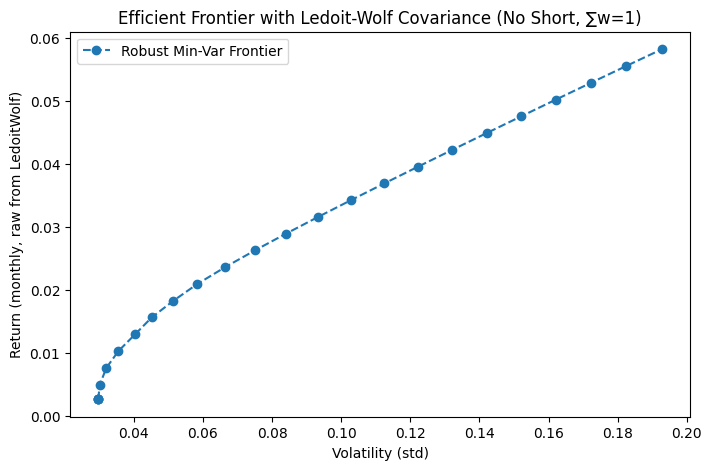

In [32]:
plt.figure(figsize=(8, 5))
plt.plot(df_frontier["Volatility"], df_frontier["Return"], 'o--', label="Robust Min-Var Frontier")
plt.xlabel("Volatility (std)")
plt.ylabel("Return (monthly, raw from LedoitWolf)")
plt.title("Efficient Frontier with Ledoit-Wolf Covariance (No Short, ∑w=1)")
plt.legend()
plt.show()


## Rolling Window Analysis

In the real world, we don't use the whole historical sample to one covariance estimate,
because markets evolve over time. We can instead recast our problem as a
rolling-window configuration. We estimate the covariance matrix (Ledoit-Wolf) for every window (e.g., 24 months), then optimize the portfolio.
We go by some step size, re-estimate, and repeat. This simulates a more realistic rebalancing strategy.


In [33]:
window_size = 24  # 24 months
step_size = 3     # Rebalance every 3 months

all_dates = returns_data.index
frontier_by_date = {}  # Store frontier for each rebalancing date

for start_idx in range(0, len(all_dates) - window_size, step_size):
    end_idx = start_idx + window_size
    window_returns = returns_data.iloc[start_idx:end_idx, :]

    # Fit LedoitWolf for the rolling window
    lw = LedoitWolf().fit(window_returns.values)
    mean_vec_rolling = lw.location_
    cov_rolling = lw.covariance_

    # We'll choose just the "max Sharpe" or "global minimum variance" for simplicity
    def portfolio_variance(w): return w @ cov_rolling @ w

    # Global min variance (no target return constraint)
    cons_gmv = [sum_weights_constraint]
    res_gmv = minimize(
        fun=portfolio_variance,
        x0=np.ones(n_assets)/n_assets,
        method='SLSQP',
        bounds=bounds_no_short,
        constraints=cons_gmv
    )

    # Store date & results
    rebal_date = all_dates[end_idx]  # The date after the window
    if res_gmv.success:
        w_gmv = res_gmv.x
        ret_gmv = np.dot(w_gmv, mean_vec_rolling)
        vol_gmv = np.sqrt(w_gmv @ cov_rolling @ w_gmv)
        frontier_by_date[rebal_date] = {
            'Weights': w_gmv,
            'Return': ret_gmv,
            'Volatility': vol_gmv
        }

# 'frontier_by_date' now has a dictionary of global-min-variance solutions at each rolling period.


# Testing Comparisons: Robust (Ledoit-Wolf) vs. Sample Covariance

In [34]:
from sklearn.covariance import LedoitWolf

# Sample Covariance
sample_cov = returns_data.cov().values
sample_mean = returns_data.mean().values

# Ledoit-Wolf Covariance
lw = LedoitWolf().fit(returns_data.values)
lw_cov = lw.covariance_
lw_mean = lw.location_


In [35]:
from scipy.optimize import minimize

def portfolio_volatility(weights, cov):
    return np.sqrt(weights @ cov @ weights)

def portfolio_return(weights, mean_r):
    return np.dot(weights, mean_r)

def min_variance_for_target_return(mean_r, cov, target_ret, bounds, constraints):
    def port_variance(w):
        return w @ cov @ w
    target_constraint = {
        'type': 'ineq',
        'fun': lambda w: np.dot(w, mean_r) - target_ret
    }
    # Combine with user-defined constraints (e.g., sum of weights=1, no short)
    all_constraints = [target_constraint] + constraints
    init_guess = np.ones(len(mean_r)) / len(mean_r)

    result = minimize(
        fun=port_variance,
        x0=init_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=all_constraints
    )
    return result

def build_frontier(mean_r, cov, n_points=25, bounds=None, constraints=None):
    """Generate points on the min-var frontier from min to max mean."""
    min_ret = mean_r.min()
    max_ret = mean_r.max()
    target_returns = np.linspace(min_ret, max_ret, n_points)
    frontier = []

    for tr in target_returns:
        res = min_variance_for_target_return(mean_r, cov, tr, bounds, constraints)
        if res.success:
            w_opt = res.x
            ret = portfolio_return(w_opt, mean_r)
            vol = portfolio_volatility(w_opt, cov)
            frontier.append((ret, vol, w_opt))
    return pd.DataFrame(frontier, columns=["Return", "Volatility", "Weights"])


In [36]:
n_assets = len(sample_mean)
# Example: sum of weights=1, no short selling
constraints_no_short = [{
    'type': 'eq',
    'fun': lambda w: np.sum(w) - 1
}]
bounds_no_short = [(0.0, 1.0)] * n_assets

frontier_sample = build_frontier(sample_mean, sample_cov, n_points=20,
                                 bounds=bounds_no_short, constraints=constraints_no_short)
frontier_lw = build_frontier(lw_mean, lw_cov, n_points=20,
                             bounds=bounds_no_short, constraints=constraints_no_short)


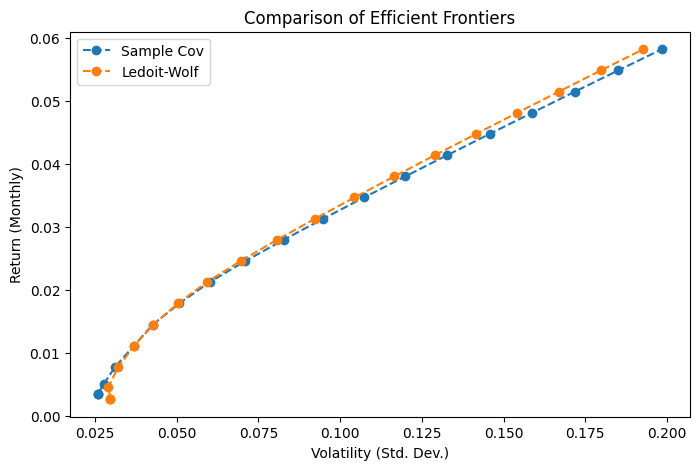

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(frontier_sample["Volatility"], frontier_sample["Return"], 'o--', label='Sample Cov')
plt.plot(frontier_lw["Volatility"], frontier_lw["Return"], 'o--', label='Ledoit-Wolf')
plt.xlabel("Volatility (Std. Dev.)")
plt.ylabel("Return (Monthly)")
plt.title("Comparison of Efficient Frontiers")
plt.legend()
plt.show()


# Naive 1/N Portfolio vs. Optimized

In [38]:
num_assets = returns_data.shape[1]
w_naive = np.ones(num_assets) / num_assets


In [39]:
# Suppose returns_data is an (N x #assets) DataFrame
# Weighted sum to get portfolio returns
naive_port_returns = (returns_data * w_naive).sum(axis=1)


In [40]:
optimized_port = frontier_lw.iloc[len(frontier_lw)//2]
w_optimized = optimized_port["Weights"]
opt_port_returns = (returns_data * w_optimized).sum(axis=1)


In [41]:
def annualize_return(monthly_returns, periods_per_year=12):
    avg_monthly_ret = monthly_returns.mean()
    return (1 + avg_monthly_ret)**periods_per_year - 1

def annualize_volatility(monthly_returns, periods_per_year=12):
    return monthly_returns.std() * np.sqrt(periods_per_year)

def sharpe_ratio(monthly_returns, risk_free=0.0, periods_per_year=12):
    excess_returns = monthly_returns - (risk_free / periods_per_year)
    ann_ret = annualize_return(excess_returns, periods_per_year)
    ann_vol = annualize_volatility(excess_returns, periods_per_year)
    return ann_ret / ann_vol


In [42]:
# Annualized Return
naive_ret = annualize_return(naive_port_returns)
opt_ret   = annualize_return(opt_port_returns)

# Annualized Volatility
naive_vol = annualize_volatility(naive_port_returns)
opt_vol   = annualize_volatility(opt_port_returns)

# Sharpe Ratios (assuming 0% risk-free for simplicity)
naive_sharpe = sharpe_ratio(naive_port_returns)
opt_sharpe   = sharpe_ratio(opt_port_returns)

print("Naive 1/N Portfolio:")
print(f" Annualized Return: {naive_ret:.2%}")
print(f" Annualized Volatility: {naive_vol:.2%}")
print(f" Sharpe Ratio: {naive_sharpe:.2f}")

print("\nOptimized Portfolio (e.g. from Ledoit-Wolf Frontier):")
print(f" Annualized Return: {opt_ret:.2%}")
print(f" Annualized Volatility: {opt_vol:.2%}")
print(f" Sharpe Ratio: {opt_sharpe:.2f}")


Naive 1/N Portfolio:
 Annualized Return: 16.54%
 Annualized Volatility: 17.66%
 Sharpe Ratio: 0.94

Optimized Portfolio (e.g. from Ledoit-Wolf Frontier):
 Annualized Return: 39.24%
 Annualized Volatility: 28.65%
 Sharpe Ratio: 1.37


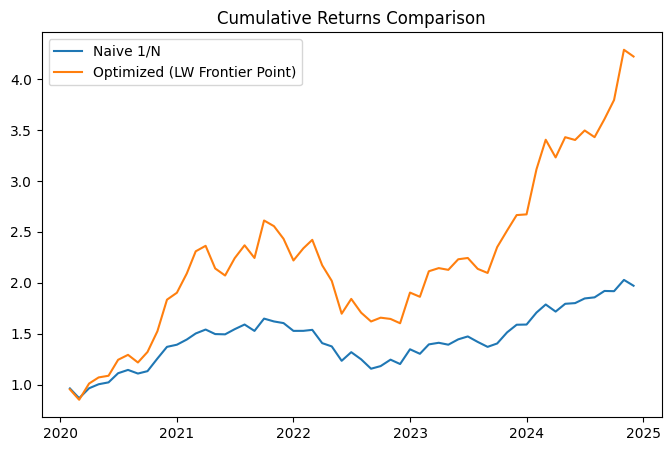

In [43]:
naive_cum = (1 + naive_port_returns).cumprod()
opt_cum   = (1 + opt_port_returns).cumprod()

plt.figure(figsize=(8,5))
plt.plot(naive_cum, label='Naive 1/N')
plt.plot(opt_cum, label='Optimized (LW Frontier Point)')
plt.title("Cumulative Returns Comparison")
plt.legend()
plt.show()
